In [89]:
import numpy as np
import pandas as pd

from pandas.api.types import CategoricalDtype

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [85]:
train = pd.read_csv('train_new.csv')
test = pd.read_csv('test_new.csv')

In [86]:
# cols = [
#     # 부동산 자체 특성 (건물·단지 속성)
#     '전용면적(㎡)', '전용면적구간', '전용면적(log)', '건축년도', '연식',
#     '계약년월', '주차대수', '브랜드명', '거래유형',

#     # 입지/지역 특성
#     '시군구', '구', 'x좌표', 'y좌표', '강남권여부', 'zone4_강남3',

#     # 교통 접근성
#     '버스거리', '지하철거리',

#     # 학군/교육 환경
#     '초등학교거리', '1km이내학교수', 'elite_min_dist_km',

#     # 시장/시세 흐름 변수
#     'target_prev6month', 'target_prev3month', '대장아파트거리'
# ]

# train = train_origin[cols + ['target']]
# test = test_origin[cols]

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109938 entries, 0 to 109937
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   전용면적(㎡)                109938 non-null  float64
 1   전용면적구간_구간화             109938 non-null  int64  
 2   전용면적(log)              109938 non-null  float64
 3   연식                     109938 non-null  float64
 4   계약월수                   109938 non-null  int64  
 5   주차대수_log               109938 non-null  float64
 6   브랜드명_단순화               109938 non-null  object 
 7   거래유형                   109938 non-null  object 
 8   구                      109938 non-null  object 
 9   x좌표                    109938 non-null  float64
 10  y좌표                    109938 non-null  float64
 11  강남권여부                  109938 non-null  float64
 12  버스거리_log               109938 non-null  float64
 13  지하철거리_log              109938 non-null  float64
 14  초등학교거리_log             109938 non-nu

In [93]:
# ===================== 유틸 =====================
def prepare_cat_dtype(X_fit, X_apply, cat_cols):
    """LGBM용: object→category, 훈/적용 동일 카테고리 집합 유지"""
    Xf = X_fit.copy(); Xa = X_apply.copy()
    for c in cat_cols:
        tr_c = Xf[c].astype('category')
        te_c = Xa[c].astype('category')
        all_cats = pd.Index(tr_c.cat.categories).union(pd.Index(te_c.cat.categories))
        cat_type = CategoricalDtype(categories=all_cats)
        Xf[c] = tr_c.astype(cat_type)
        Xa[c] = te_c.astype(cat_type)
    return Xf, Xa

def align_lgb_columns(X_fit_lgb, X_apply_lgb, cat_cols):
    """(안전장치) LGBM 입력 열 일치(누락 추가/여분 제거/순서 정렬)"""
    X_fit = X_fit_lgb.copy()
    X_app = X_apply_lgb.copy()
    # 누락 열 추가
    for col in X_fit.columns:
        if col not in X_app.columns:
            if col in cat_cols:
                cats = X_fit[col].cat.categories if str(X_fit[col].dtype) == 'category' else None
                X_app[col] = pd.Categorical([np.nan]*len(X_app), categories=cats)
            else:
                fill = pd.to_numeric(X_fit[col], errors='coerce').median()
                X_app[col] = fill
    # 여분 열 제거
    extra_cols = [c for c in X_app.columns if c not in X_fit.columns]
    if extra_cols:
        X_app = X_app.drop(columns=extra_cols)
    # 순서 맞추기
    X_app = X_app[X_fit.columns]
    return X_app

def bias_sigma2_from_val(y_true, y_pred_log):
    """log1p 스케일 잔차 분산 σ² 추정"""
    res = np.log1p(y_true) - y_pred_log
    return float(np.mean(res**2))

# ===================== 0) 공통 준비 =====================
# 타깃/피처 분리
y_all_log = np.log1p(train['target_clipped'])
X_all = train.drop(columns=['target_clipped']).copy()
X_test = test.copy()

# 범주형 컬럼
cat_cols = X_all.select_dtypes(include=['object']).columns.tolist()  # ['브랜드명_단순화','거래유형','구'] 예상

# ===================== 1) 캘리브레이션 (최근 1개월로 σ² 추정) =====================
last_month = np.sort(train['계약월수'].unique())[-1]
cal_tr_idx = train['계약월수'] < last_month
cal_va_idx = train['계약월수'] == last_month

X_cal_tr = X_all.loc[cal_tr_idx].copy()
y_cal_tr_log = y_all_log.loc[cal_tr_idx].copy()

X_cal_va = X_all.loc[cal_va_idx].copy()
y_cal_va_true = train.loc[cal_va_idx, 'target_clipped'].copy()
y_cal_va_log = np.log1p(y_cal_va_true)

# LGBM용: category
X_cal_tr_lgb, X_cal_va_lgb = prepare_cat_dtype(X_cal_tr, X_cal_va, cat_cols)

# XGB용: 원핫 + 열 정렬
X_cal_tr_xgb = pd.get_dummies(X_cal_tr, columns=cat_cols)
X_cal_va_xgb = pd.get_dummies(X_cal_va, columns=cat_cols)
X_cal_tr_xgb, X_cal_va_xgb = X_cal_tr_xgb.align(X_cal_va_xgb, join='left', axis=1, fill_value=0)

# LightGBM (calibration)
lgb_cal = LGBMRegressor(
    random_state=42,
    n_estimators=800,
    learning_rate=0.06,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0
)
lgb_cal.fit(
    X_cal_tr_lgb, y_cal_tr_log,
    eval_set=[(X_cal_va_lgb, y_cal_va_log)],
    eval_metric="rmse",
    categorical_feature=X_cal_tr_lgb.select_dtypes(include=['category']).columns.tolist(),
    callbacks=[early_stopping(stopping_rounds=100, verbose=False), log_evaluation(period=0)]
)

# XGBoost (calibration)
xgb_cal = XGBRegressor(
    random_state=42,
    objective="reg:squarederror",
    n_estimators=800,
    learning_rate=0.06,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    n_jobs=-1,
    eval_metric="rmse"
)
xgb_cal.fit(
    X_cal_tr_xgb, y_cal_tr_log,
    eval_set=[(X_cal_va_xgb, y_cal_va_log)],
    verbose=False
)

# 검증 예측(로그) → σ² 추정
cal_va_pred_log = 0.5*lgb_cal.predict(X_cal_va_lgb) + 0.5*xgb_cal.predict(X_cal_va_xgb)
sigma2 = bias_sigma2_from_val(y_cal_va_true.values, cal_va_pred_log)
print(f"[Calib] Estimated sigma^2 = {sigma2:.6f}  (0.5*sigma^2 = {0.5*sigma2:.6f})")

# best_iteration 기반 최종 트리 수
best_iter_lgb = getattr(lgb_cal, "best_iteration_", None)
best_iter_xgb = getattr(xgb_cal, "best_iteration", None)  # sklearn API
n_estimators_lgb_final = int(best_iter_lgb if best_iter_lgb is not None else lgb_cal.n_estimators)
n_estimators_xgb_final = int(best_iter_xgb if best_iter_xgb is not None else xgb_cal.n_estimators)
print("[Best iters] LGBM:", n_estimators_lgb_final, " / XGB:", n_estimators_xgb_final)

# (캘리브레이션 달) 원스케일 RMSE: 기본/보정 둘 다
rmse_cal_basic = mean_squared_error(y_cal_va_true, np.expm1(cal_va_pred_log), squared=False)
rmse_cal_bias  = mean_squared_error(y_cal_va_true, np.expm1(cal_va_pred_log + 0.5*sigma2), squared=False)
print('기본 RMSE 값: ', rmse_cal_basic)
print('보정 RMSE 값: ', rmse_cal_bias)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3182
[LightGBM] [Info] Number of data points in the train set: 107535, number of used features: 20
[LightGBM] [Info] Start training from score 10.964607
[Calib] Estimated sigma^2 = 0.011155  (0.5*sigma^2 = 0.005577)
[Best iters] LGBM: 800  / XGB: 800
기본 RMSE 값:  12082.014507621197
보정 RMSE 값:  11956.434737609494


In [94]:
# ===================== 2) 전체 재학습 =====================
# LGBM: Train/Test 카테고리 동기화 + 열 일치(안전)
X_all_lgb, X_test_lgb = prepare_cat_dtype(X_all, X_test, cat_cols)
X_test_lgb = align_lgb_columns(X_all_lgb, X_test_lgb, cat_cols)

# XGB: 전체+테스트 합쳐 원핫 후 분리(열 완전일치 보장)
X_concat = pd.concat([X_all, X_test], axis=0, ignore_index=True)
X_concat_xgb = pd.get_dummies(X_concat, columns=cat_cols)
X_all_xgb = X_concat_xgb.iloc[:len(X_all)].copy()
X_test_xgb = X_concat_xgb.iloc[len(X_all):].copy()

# 최종 모델 학습 (early stopping 없이 깔끔히)
lgb_final = LGBMRegressor(
    random_state=42,
    n_estimators=n_estimators_lgb_final,
    learning_rate=0.06,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0
)
lgb_final.fit(X_all_lgb, y_all_log,
              categorical_feature=X_all_lgb.select_dtypes(include=['category']).columns.tolist())

xgb_final = XGBRegressor(
    random_state=42,
    objective="reg:squarederror",
    n_estimators=n_estimators_xgb_final,
    learning_rate=0.06,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    n_jobs=-1,
    eval_metric="rmse"
)
xgb_final.fit(X_all_xgb, y_all_log, verbose=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3181
[LightGBM] [Info] Number of data points in the train set: 109938, number of used features: 20
[LightGBM] [Info] Start training from score 10.973771


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.06, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=-1, num_parallel_tree=None, ...)

In [102]:
# ===================== 3) Test 예측 → 역변환(+보정) =====================
test_pred_log = 0.5*lgb_final.predict(X_test_lgb) + 0.5*xgb_final.predict(X_test_xgb)

# (a) 기본 역변환
test_pred_basic = np.expm1(test_pred_log)

# (b) 바이어스 보정 역변환 (권장)
test_pred_biascorr = np.expm1(test_pred_log + 0.5*sigma2)
test_target = np.rint(test_pred_biascorr).astype(int)

In [104]:
# ===================== 4) 저장 =====================
submit = pd.DataFrame({
    'id': test.index if 'id' not in test.columns else test['id'],
    'target': test_target
})
submit.to_csv('submission.csv', index=False, encoding='utf-8-sig')

# # 비교용(보정 없이)
# pd.DataFrame({'id': submit['id'], 'target': test_pred_basic}).to_csv('submission_basic.csv', index=False, encoding='utf-8-sig')

# print("Saved: submission.csv (bias-corrected) & submission_basic.csv (plain expm1)")

In [105]:
print(train['target_clipped'].min())
print(train['target_clipped'].max())

6000.0
270000.0


In [106]:
submission = pd.read_csv('submission.csv')

In [107]:
print(submission['target'].min())
print(submission['target'].max())

8366
321820


=== Summary (train target_clipped) ===
count    109938.000000
mean      69703.847787
std       46499.243395
min        6000.000000
1%        13800.000000
5%        23700.000000
10%       29000.000000
25%       40000.000000
50%       56500.000000
75%       83500.000000
90%      130000.000000
95%      165000.000000
99%      270000.000000
max      270000.000000
Name: target_clipped, dtype: float64

=== Summary (submission target) ===
count      9272.000000
mean      89364.210634
std       46200.873544
min        8366.000000
1%        11604.850000
5%        33138.100000
10%       42734.000000
25%       58629.750000
50%       80683.000000
75%      109310.750000
90%      147536.300000
95%      181608.850000
99%      248657.930000
max      321820.000000
Name: target, dtype: float64

Outside train range -> above max: 0.399%, below min: 0.000%


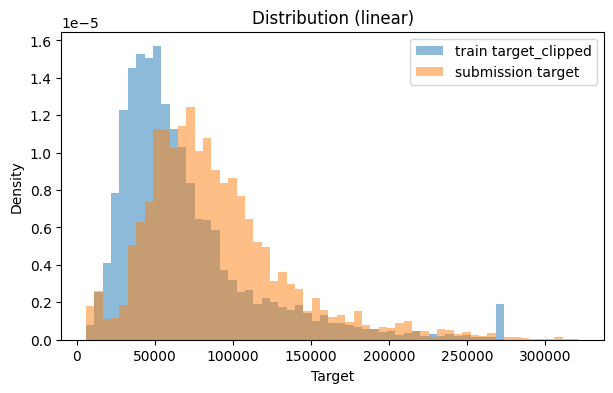

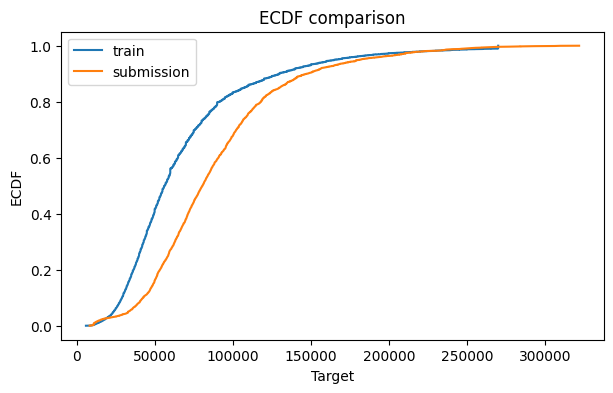

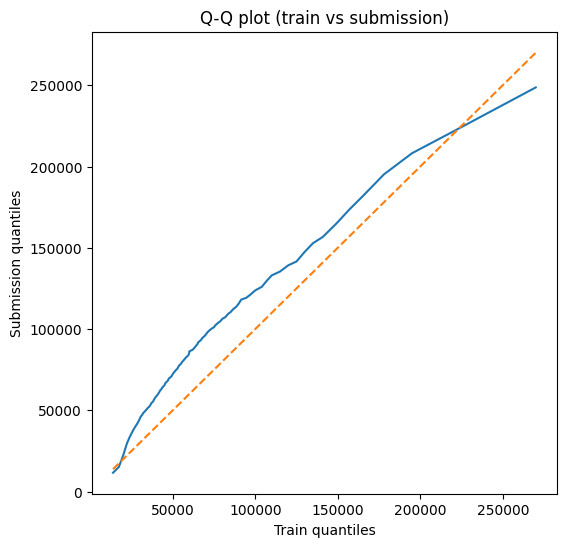

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) 제출 파일 읽어온 뒤, 자료형 확인
# submission = pd.read_csv("submission.csv")  # 이미 있다면 생략
sub = submission['target'].astype(float)
tr  = train['target_clipped'].astype(float)

# 1) 요약 통계 + 구간 밖 비율
print("=== Summary (train target_clipped) ===")
print(tr.describe([.01,.05,.1,.25,.5,.75,.9,.95,.99]))
print("\n=== Summary (submission target) ===")
print(sub.describe([.01,.05,.1,.25,.5,.75,.9,.95,.99]))

lo, hi = tr.min(), tr.max()
over_share  = (sub > hi).mean()
under_share = (sub < lo).mean()
print(f"\nOutside train range -> above max: {over_share*100:.3f}%, below min: {under_share*100:.3f}%")

# 2) 겹쳐 보는 히스토그램 (선형 스케일)
bins = np.linspace(lo, max(hi, sub.max()), 60)
plt.figure(figsize=(7,4))
plt.hist(tr,  bins=bins, alpha=0.5, density=True, label='train target_clipped')
plt.hist(sub, bins=bins, alpha=0.5, density=True, label='submission target')
plt.xlabel("Target"); plt.ylabel("Density"); plt.title("Distribution (linear)")
plt.legend(); plt.show()

# 3) ECDF(누적분포) - bin 민감도 없이 전체 모양 비교
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x1,y1 = ecdf(tr);  x2,y2 = ecdf(sub)
plt.figure(figsize=(7,4))
plt.plot(x1,y1, label='train')
plt.plot(x2,y2, label='submission')
plt.xlabel("Target"); plt.ylabel("ECDF"); plt.title("ECDF comparison")
plt.legend(); plt.show()

# 4) Q-Q plot (분포형태 차이 체크)
qs = np.linspace(0.01, 0.99, 99)
tr_q  = np.quantile(tr,  qs)
sub_q = np.quantile(sub, qs)
plt.figure(figsize=(6,6))
plt.plot(tr_q, sub_q)
m, M = tr_q.min(), tr_q.max()
plt.plot([m, M], [m, M], '--')  # y=x 기준선
plt.xlabel("Train quantiles"); plt.ylabel("Submission quantiles")
plt.title("Q-Q plot (train vs submission)")
plt.show()

In [111]:
lo, hi = train['target_clipped'].min(), train['target_clipped'].max()
sub = submission['target'].astype(float)

# 1) train 상한 초과 비율
over_share = (sub > hi).mean()
print(f"상한 {hi} 초과 비율: {over_share*100:.3f}%")

# 2) 99/99.5/99.9 분위 비교
qs = [0.99, 0.995, 0.999]
tr_q = train['target_clipped'].quantile(qs)
sub_q = sub.quantile(qs)
print("train high-quantiles:\n", tr_q)
print("submission high-quantiles:\n", sub_q)

# 3) '가장 최신 달'(last_month) 실제 vs 우리가 그 달에서 만든 예측(캘리브레이션) 비교
from sklearn.metrics import mean_squared_error
pred_val_bias = np.expm1(cal_va_pred_log + 0.5*sigma2)  # 우리가 제출에 쓰는 방식
rmse_nc   = mean_squared_error(y_cal_va_true, pred_val_bias, squared=False)
rmse_clip = mean_squared_error(y_cal_va_true, np.clip(pred_val_bias, lo, hi), squared=False)
print(f"Calib RMSE no-clip={rmse_nc:,.2f} | clip-to-[{lo},{hi}]={rmse_clip:,.2f}")

상한 270000.0 초과 비율: 0.399%
train high-quantiles:
 0.990    270000.0
0.995    270000.0
0.999    270000.0
Name: target_clipped, dtype: float64
submission high-quantiles:
 0.990    248657.930
0.995    265827.675
0.999    305943.845
Name: target, dtype: float64
Calib RMSE no-clip=11,956.43 | clip-to-[6000.0,270000.0]=11,026.63
